In [1]:
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from pathlib import Path

In [13]:
import random

## Load sample images

In [22]:
raw_im_dir = Path("../data/bundled/input_train/")
true_he_dir = Path("../data/bundled/input_ce_train/")

In [14]:
raw_ims_paths = list(raw_im_dir.glob("*"))

In [44]:
sampled_ims_paths = random.sample(raw_ims_paths, k=10)

In [45]:
bgrs = [cv2.imread(i.as_posix()) for i in sampled_ims_paths]
rgbs = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in bgrs]

In [46]:
sampled_ims_paths[0].name

'556_img_.jpg'

In [47]:
true_hes = [cv2.imread((true_he_dir / i.name).as_posix()) for i in sampled_ims_paths]

In [48]:
true_hes_rgb = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in true_hes]

In [6]:
def white_balance(img, percent=0):
    # Meant to be used on BGR numpy array as uint8
    out_channels = []
    cumstops = (
        img.shape[0] * img.shape[1] * percent / 200.0,
        img.shape[0] * img.shape[1] * (1 - percent / 200.0)
    )
    for channel in cv2.split(img):
        cumhist = np.cumsum(cv2.calcHist([channel], [0], None, [256], (0,256)))
        low_cut, high_cut = np.searchsorted(cumhist, cumstops)
        lut = np.concatenate((
            np.zeros(low_cut),
            np.around(np.linspace(0, 255, high_cut - low_cut + 1)),
            255 * np.ones(255 - high_cut)
        ))
        out_channels.append(cv2.LUT(channel, lut.astype('uint8')))
    img = cv2.merge(out_channels)
    return img

In [7]:
wb_sample = white_balance(sample_bgr, percent=0.5)

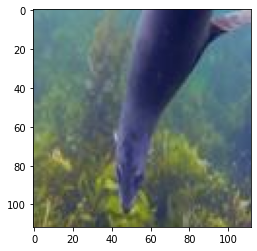

In [9]:
plt.imshow(sample_rgb)

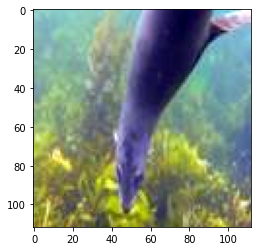

In [10]:
plt.imshow(cv2.cvtColor(wb_sample, cv2.COLOR_BGR2RGB))

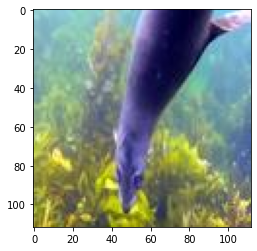

In [26]:
plt.imshow(true_wb_rgb)

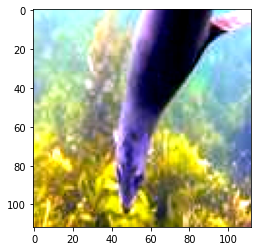

In [12]:
plt.imshow(cv2.cvtColor(white_balance(sample_bgr, percent=15), cv2.COLOR_BGR2RGB))

Did some prelim searching, apparently there isn't a standard method for adjusting white balance. Some histogram matching is required. Thus, no convenient implementations are included in PIL or OpenCV.

This implementation is usable as-is. Not gonna bother with replacing the OpenCV functions to reduce dependencies.

## Histogram Equalization

In [53]:
candidates = [1E-2, 0.1, 0.5, 1, 3, 5, 10]

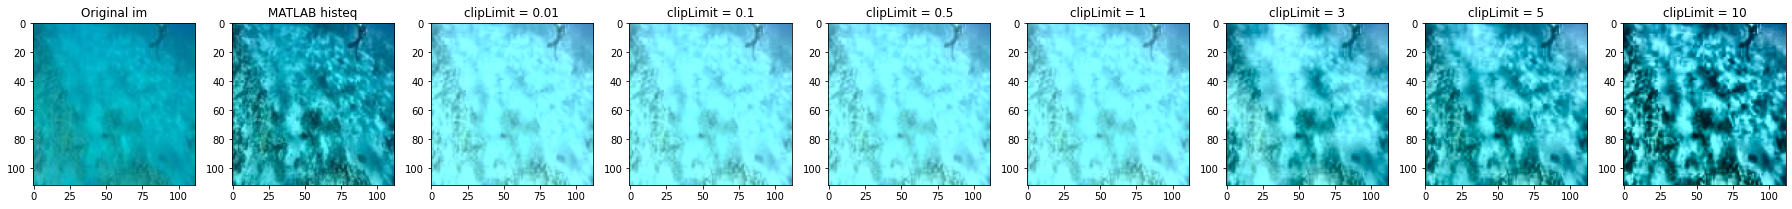

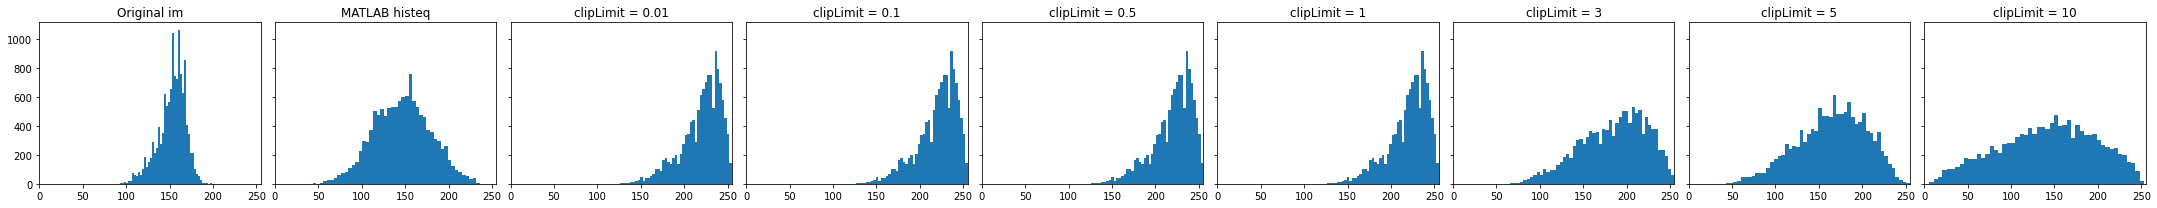

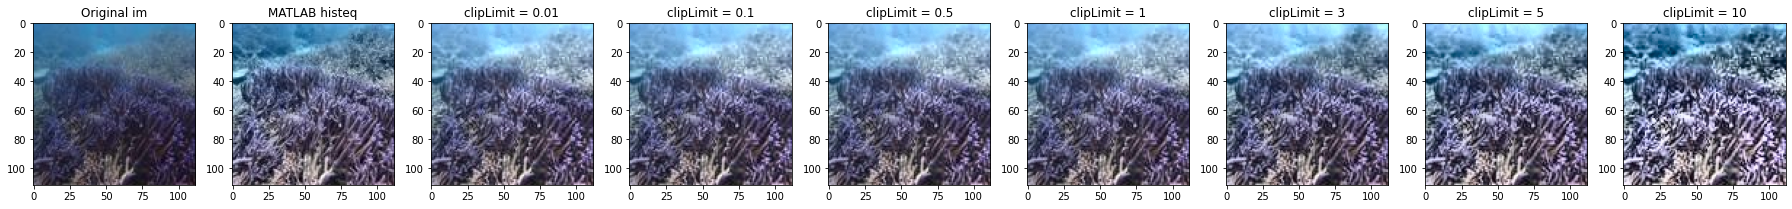

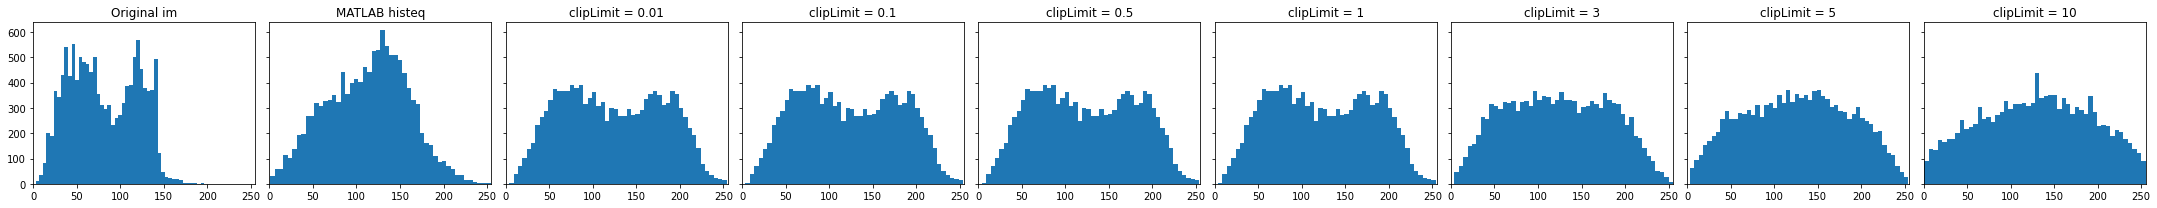

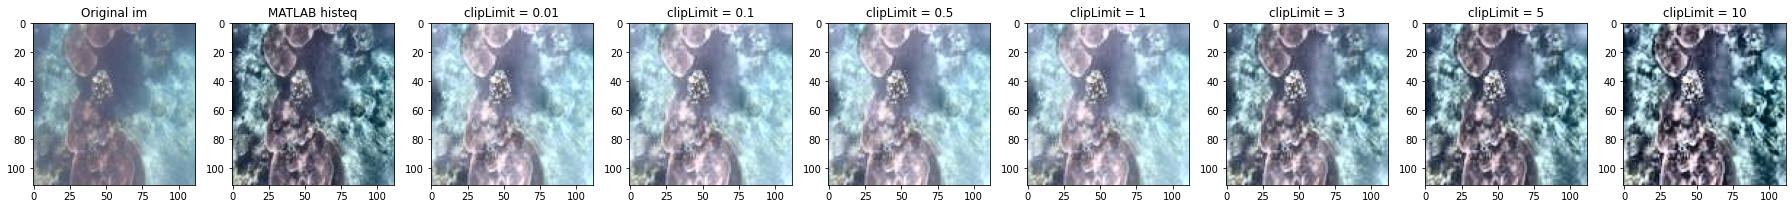

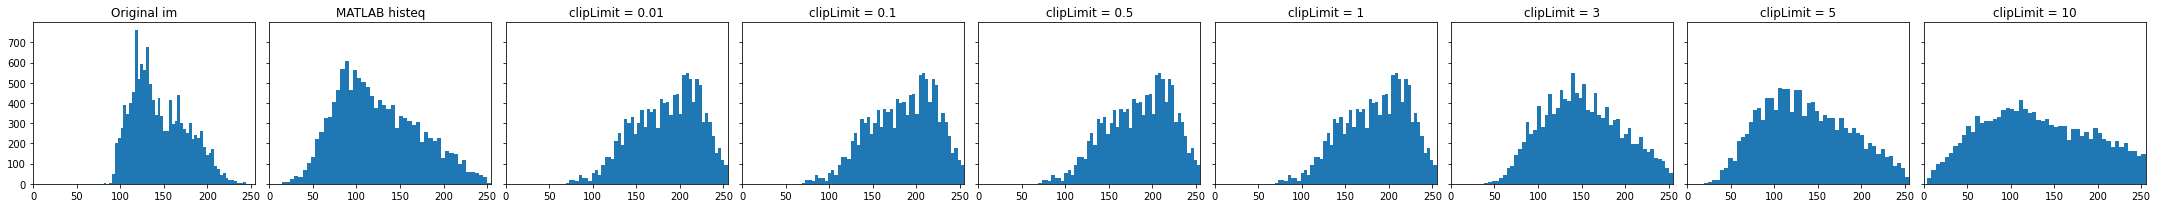

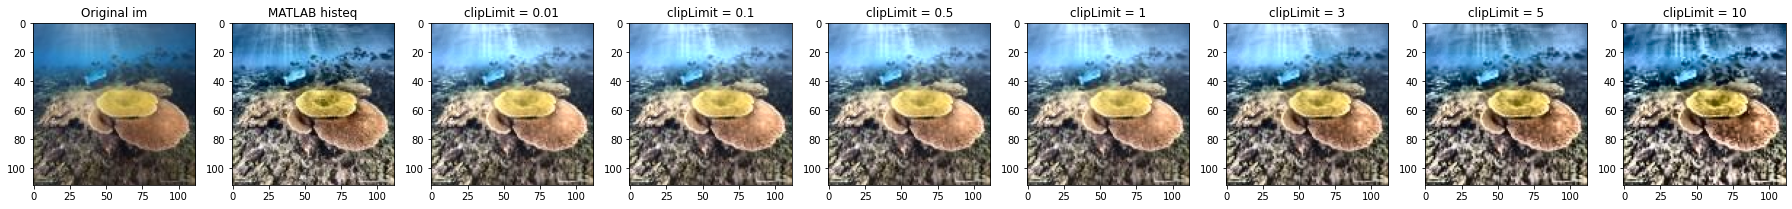

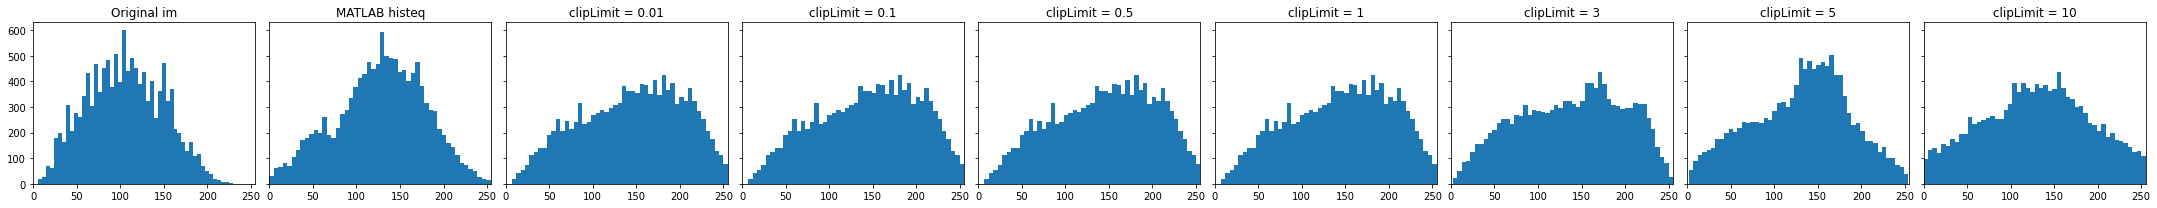

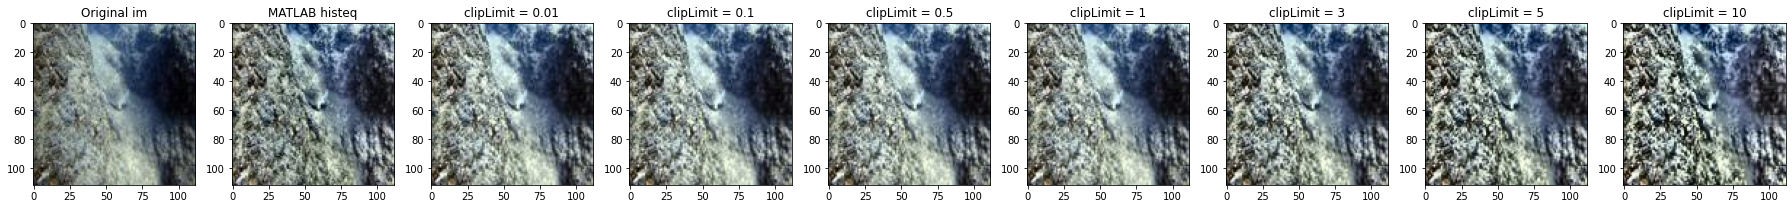

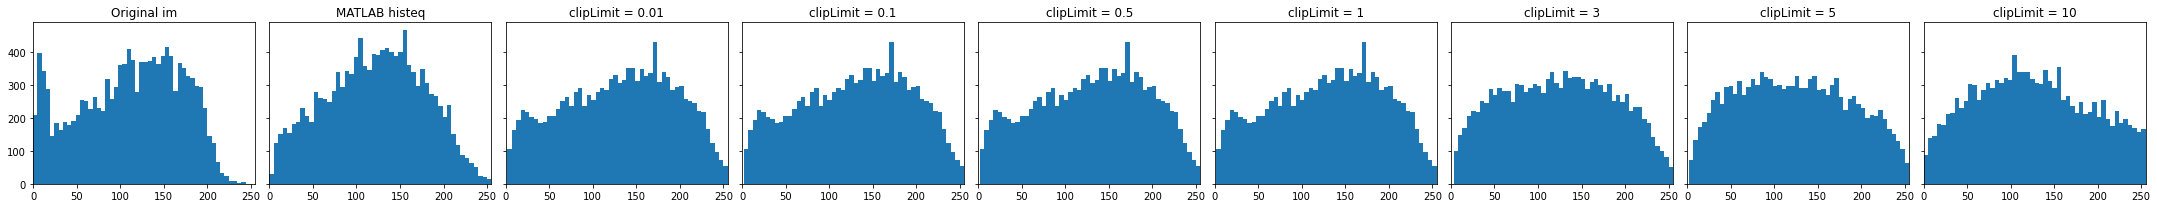

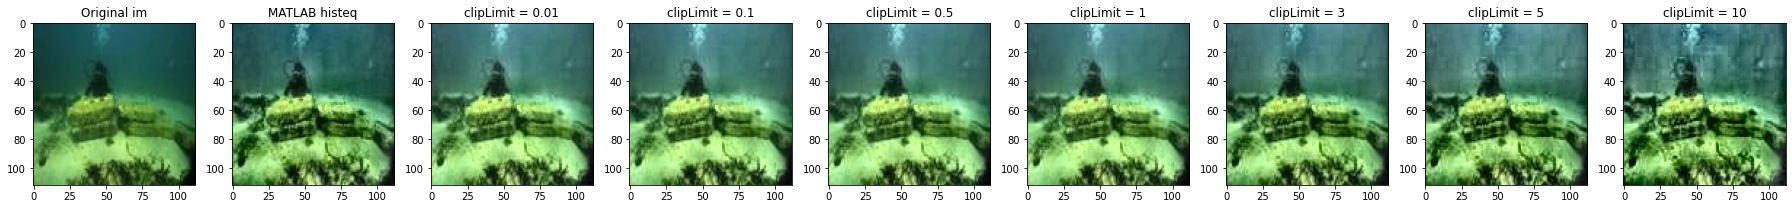

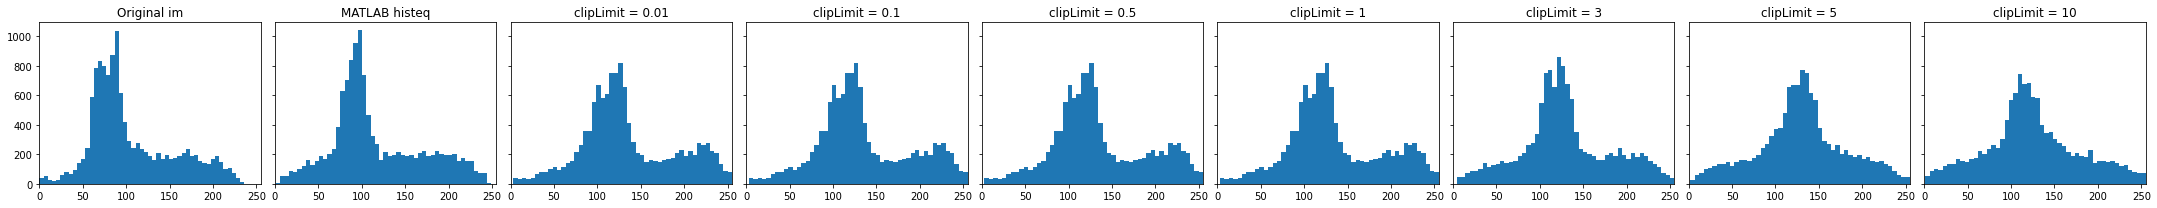

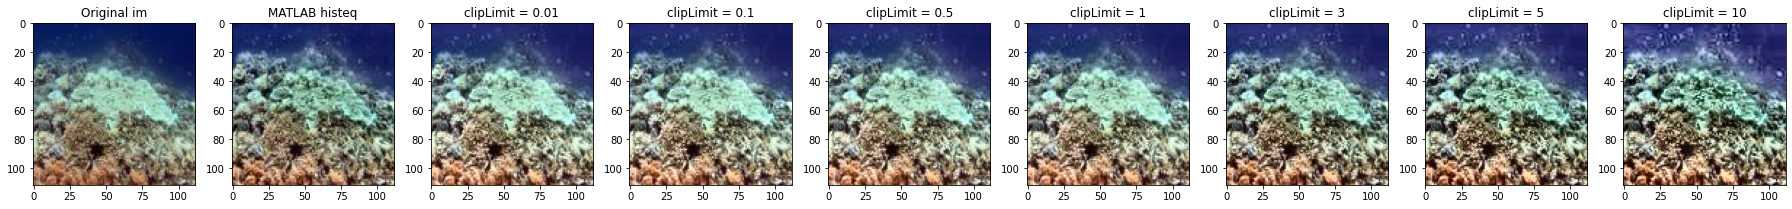

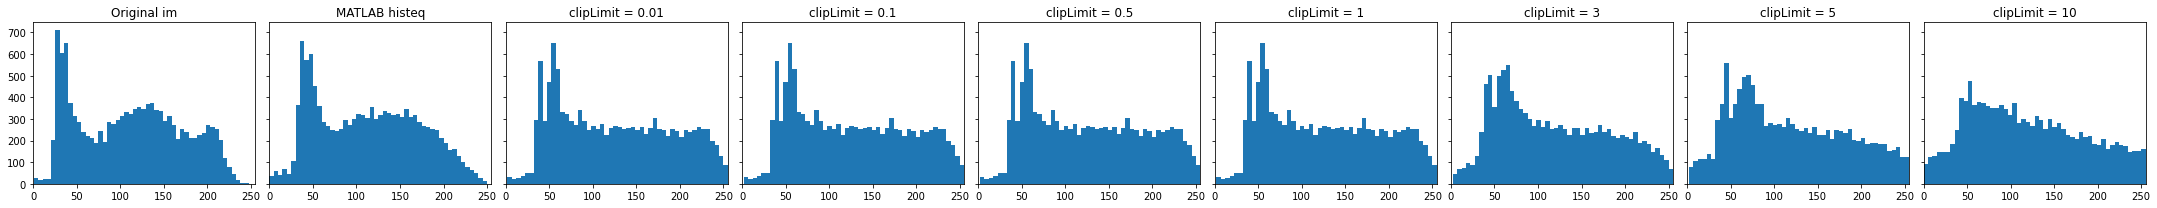

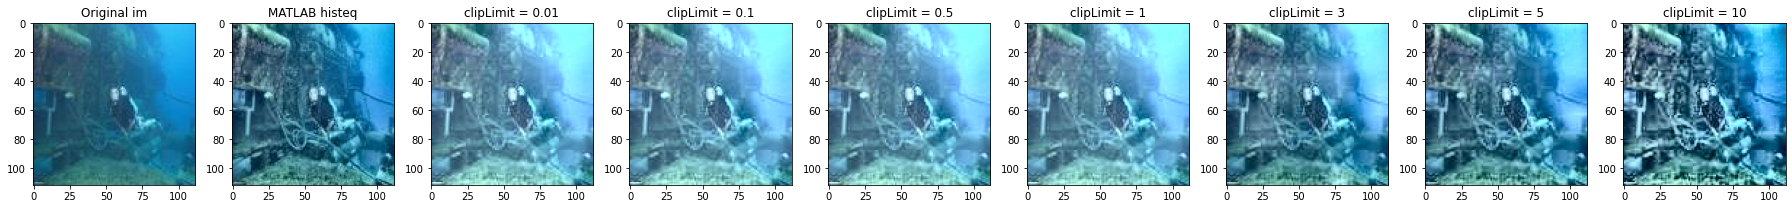

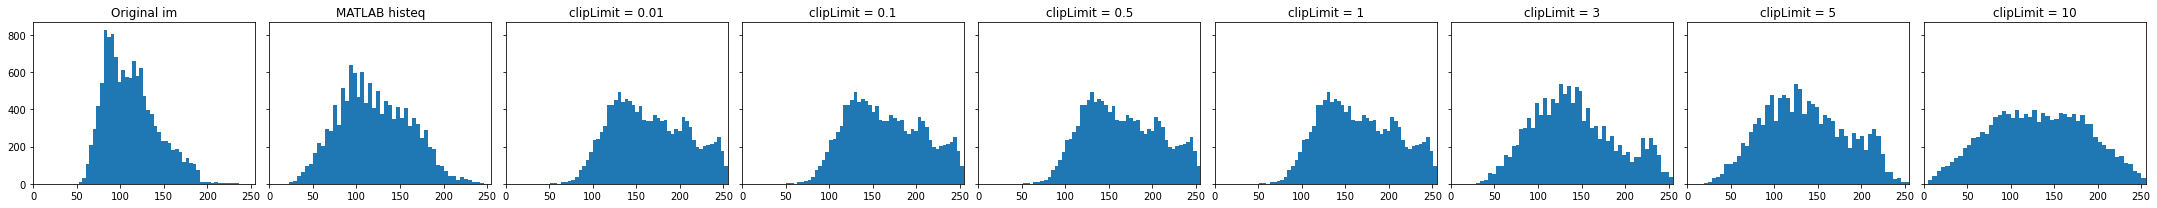

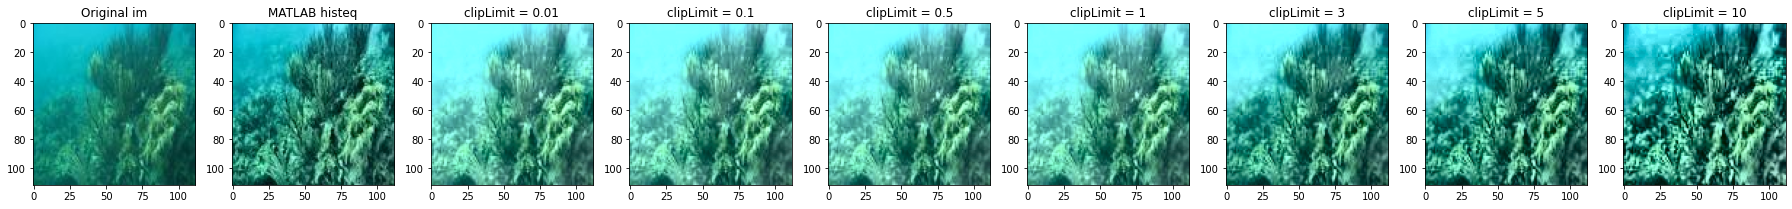

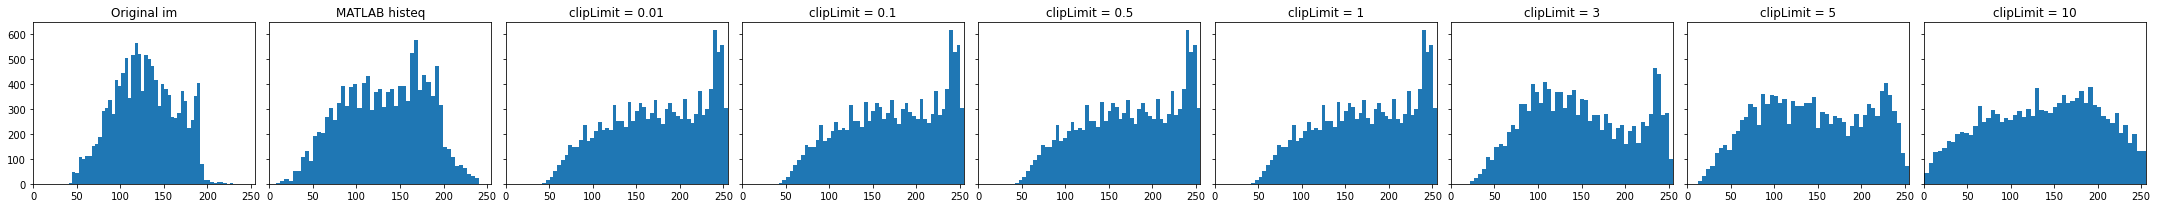

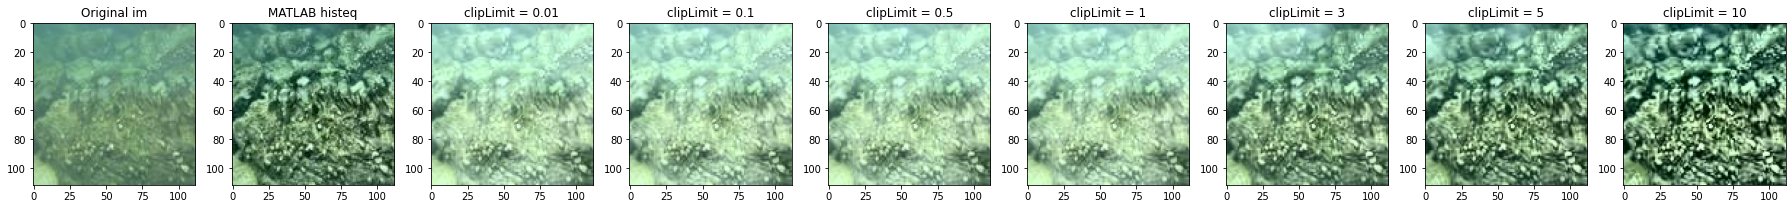

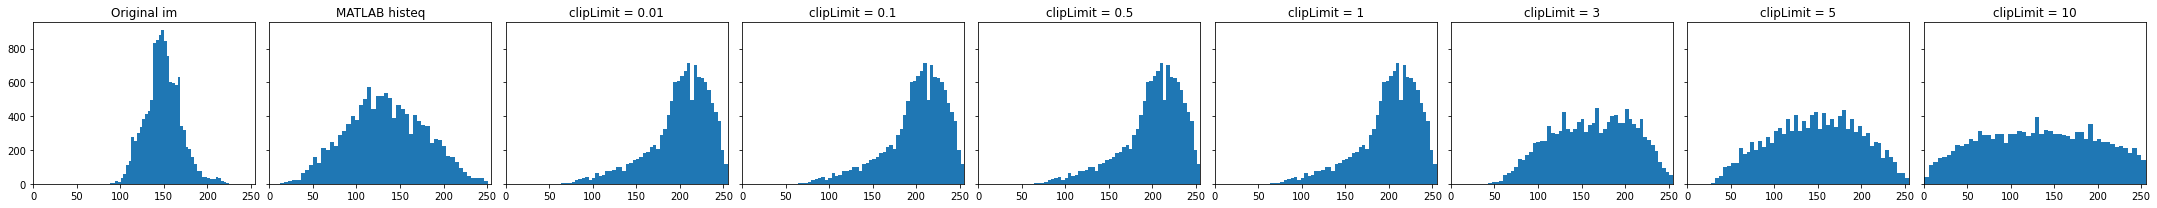

In [54]:
for im_rgb, im_he_true in zip(rgbs, true_hes_rgb):

    im_lab = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2LAB)
    im_he_lab = cv2.cvtColor(im_he_true, cv2.COLOR_RGB2LAB)
    
    # Two plots, one for the images, one for the histograms
    # Two extra panes to show original and MATLAB histeq
    fig1, ax1 = plt.subplots(ncols=len(candidates)+2, figsize=(25, 5))
    fig2, ax2 = plt.subplots(ncols=len(candidates)+2, figsize=(30, 3), sharex=True, sharey=True)
    
    for count, i in enumerate(candidates):
        
        clahe = cv2.createCLAHE(clipLimit=i, tileGridSize=(8,8))
        el = clahe.apply(im_lab[:, :, 0])

        im_he = im_lab.copy()
        im_he[:, :, 0] = el
        im_he_rgb = cv2.cvtColor(im_he, cv2.COLOR_LAB2RGB)

        ax1[count+2].imshow(im_he_rgb)
        ax1[count+2].set_title(f"clipLimit = {i}")
        
        ax2[count+2].hist(el.ravel(), bins=50)
        ax2[count+2].set_title(f"clipLimit = {i}")
    
    ax1[0].imshow(im_rgb)
    ax1[0].set_title(f"Original im")
    ax1[1].imshow(im_he_true)
    ax1[1].set_title(f"MATLAB histeq")
    fig1.tight_layout()
    
    ax2[0].hist(im_lab[:, :, 0].ravel(), bins=50)
    ax2[0].set_title(f"Original im")
    ax2[0].set_xlim(0, 255)
    ax2[1].hist(im_he_lab[:, :, 0].ravel(), bins=50)
    ax2[1].set_title(f"MATLAB histeq")
    fig2.tight_layout()
    
    plt.show()

Values too large will amplify noise, which is the opposite effect. 

The original source code used `adapthisteq` without any arguments, so the params should be using default args. The implementation is different across both toolkits. MATLAB's ClipLimit arg defaults to 1e-2 and is bounded from 0 to 1, while OpenCV's clipLimit is unbounded. 

Not possible to replicate MATLAB's behaviour without implementing the algorithm from scratch. Moving ahead using OpenCV's implementation in the interest of keeping the stack in Python. Just gonna stick to clipLimit = 0.1 which appears somewhat safe.